## Loading libraries

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import time
import lightgbm as lgbm
from pathlib import Path
import pickle
from catboost import CatBoostClassifier, cv, Pool
import scikitplot as skplt
from hyperopt import tpe, STATUS_OK, Trials, hp, fmin, tpe, partial

import itertools
from itertools import combinations

import scipy as sp
from scipy.stats import pearsonr, chi2_contingency

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap

from datetime import datetime
from dateutil import relativedelta

from IPython.display import display
pd.options.display.max_columns = None
pd.options.display.max_colwidth = None
pd.options.display.max_rows = None

import statsmodels.api as sm 
from statsmodels.graphics.api import abline_plot # For visualling evaluating predictions.
from statsmodels.stats.proportion import proportion_confint

import warnings # For handling error messages.
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings('ignore')

import sklearn.metrics as met
from sklearn import linear_model, preprocessing, model_selection, svm, datasets
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2, RFE
from sklearn.linear_model import LassoCV, LogisticRegression, Lasso
from sklearn.metrics import plot_confusion_matrix, auc, confusion_matrix, classification_report, accuracy_score, roc_curve, roc_auc_score, plot_roc_curve
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import scale, StandardScaler, LabelEncoder, MinMaxScaler, Binarizer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from bayes_opt import BayesianOptimization
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
from bayes_opt.util import load_logs

## Loading dataset

In [2]:
df = pd.read_csv('df2.csv', index_col='id') 
dummies = pd.read_csv('dummies2.csv', index_col='id') 

## Modeling

### Dropping paid off status, datetime objs, and letter grades.

In [3]:
dummies.drop(['loan_sta_Fully Paid', 'issue_d', 'earliest_cr_line','gra_A', 'gra_B','gra_C','gra_D','gra_E','gra_F','gra_G'], axis=1,inplace=True)
X = dummies.drop('loan_sta_Charged Off', axis=1)
y = dummies['loan_sta_Charged Off'].values 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)
# build scaler based on training data and apply it to test data to then also scale the test data
# scaler = StandardScaler().fit(X_train)
# X_train_scaled = scaler.transform(X_train)
# X_test_scaled = scaler.transform(X_test)

### Testing different LightGBM models using Bayesian Boosting
#### gbdt: traditional Gradient Boosting Decision Tree
#### rf: Random Forest
#### dart: Dropouts meet Multiple Additive Regression Trees
#### goss: Gradient-based One-Side Sampling

In [4]:
categorical_features = ['pur_car','pur_credit_card','pur_debt_consolidation','pur_educational','pur_home_improvement','pur_house','pur_major_purchase','pur_medical','pur_moving','pur_other','pur_renewable_energy','pur_small_business','pur_vacation','pur_wedding','hom_own_ANY','hom_own_MORTGAGE','hom_own_NONE','hom_own_OTHER','hom_own_OWN','hom_own_RENT','ver_sta_Not Verified','ver_sta_Source Verified','ver_sta_Verified']

In [5]:
def lgb_eval(num_leaves, lambda_l2, lambda_l1, max_depth, min_data_in_leaf, learning_rate):
    params = {
        "objective" : "binary",
        'boosting': 'gbdt',
        "metric" : "auc", 
        'is_unbalance': True,
        "num_threads" : 6,
        "num_leaves" : int(num_leaves),
        "lambda_l2" : lambda_l2,
        "lambda_l1" : lambda_l1,
        'max_depth': int(max_depth),
        'min_data_in_leaf': int(min_data_in_leaf),
        "learning_rate" : learning_rate,
        'feature_fraction': 1,
        "verbosity" : -1,
        'histogram_pool_size': 50000,
        'num_boost_round': 100,
        'early_stopping_rounds': 100
    }
    lgtrain = lgbm.Dataset(X_train, y_train,categorical_feature=categorical_features)
    cv_result = lgbm.cv(params,
                       lgtrain,
                       stratified=True,
                       nfold=2)
    return cv_result['auc-mean'][-1]

lgbBO0 = BayesianOptimization(lgb_eval, {
                                        "num_leaves" : (10, 100000),
                                        "lambda_l2" : (.1, 1),
                                        "lambda_l1" : (.1, 1),
                                        'max_depth': (10,100000),
                                        'min_data_in_leaf': (10, 100000), 
                                        "learning_rate" : (.001,.5)
#                                         'feature_fraction': (.1,1)
                                         })

# logger = JSONLogger(path="./log0.json")
# lgbBO0.subscribe(Events.OPTIMIZATION_STEP, logger)

lgbBO0.maximize(init_points=2, n_iter=2)

|   iter    |  target   | lambda_l1 | lambda_l2 | learni... | max_depth | min_da... | num_le... |
-------------------------------------------------------------------------------------------------
|  1        |  0.7103   |  0.1999   |  0.6578   |  0.05832  |  2.803e+0 |  9.166e+0 |  4.268e+0 |
|  2        |  0.7198   |  0.8888   |  0.5412   |  0.2599   |  5.583e+0 |  8.186e+0 |  1.127e+0 |
|  3        |  0.7221   |  0.169    |  0.6681   |  0.3629   |  1.8e+04  |  6.51e+04 |  9.127e+0 |
|  4        |  0.7192   |  0.2772   |  0.7179   |  0.3208   |  8.329e+0 |  9.28e+04 |  4.432e+0 |


In [7]:
def lgb_eval(num_leaves, lambda_l2, lambda_l1, max_depth, min_data_in_leaf, learning_rate, bagging_fraction):
    params = {
        "objective" : "binary",
        'boosting': 'rf',
        "metric" : "auc", 
        'is_unbalance': True,
        "num_threads" : 6,
        "num_leaves" : int(num_leaves),
        "lambda_l2" : lambda_l2,
        "lambda_l1" : lambda_l1,
        'max_depth': int(max_depth),
        'min_data_in_leaf': int(min_data_in_leaf),
        "learning_rate" : learning_rate,
        'feature_fraction': 1,
        "verbosity" : -1,
        'histogram_pool_size': 50000,
        'num_boost_round': 100,
        'early_stopping_rounds': 100,
        'bagging_freq': 1,
        'bagging_fraction': bagging_fraction
    }
    lgtrain = lgbm.Dataset(X_train, y_train,categorical_feature=categorical_features)
    cv_result = lgbm.cv(params,
                       lgtrain,
                       stratified=True,
                       nfold=2)
    return cv_result['auc-mean'][-1]

lgbBO1 = BayesianOptimization(lgb_eval, {
                                        "num_leaves" : (10, 100000),
                                        "lambda_l2" : (.1, 1),
                                        "lambda_l1" : (.1, 1),
                                        'max_depth': (10,100000),
                                        'min_data_in_leaf': (10, 100000), 
                                        "learning_rate" : (.001,.5),
#                                         'feature_fraction': (.1,1),
                                        'bagging_fraction': (.1,1)
                                         })

# logger = JSONLogger(path="./log1.json")
# lgbBO1.subscribe(Events.OPTIMIZATION_STEP, logger)

lgbBO1.maximize(init_points=2, n_iter=2)

|   iter    |  target   | baggin... | lambda_l1 | lambda_l2 | learni... | max_depth | min_da... | num_le... |
-------------------------------------------------------------------------------------------------------------
|  1        |  0.6734   |  0.8789   |  0.2652   |  0.2893   |  0.1583   |  5.091e+0 |  8.839e+0 |  4.328e+0 |
|  2        |  0.6868   |  0.3086   |  0.9184   |  0.3072   |  0.4471   |  4.96e+03 |  2.027e+0 |  4.835e+0 |
|  3        |  0.687    |  0.714    |  0.5834   |  0.8323   |  0.0295   |  5.4e+03  |  3.722e+0 |  5.574e+0 |
|  4        |  0.6979   |  0.2958   |  0.1692   |  0.6174   |  0.1399   |  1.295e+0 |  6.024e+0 |  3.992e+0 |


In [8]:
def lgb_eval(num_leaves, lambda_l2, lambda_l1, max_depth, min_data_in_leaf, learning_rate):
    params = {
        "objective" : "binary",
        'boosting': 'dart',
        "metric" : "auc", 
        'is_unbalance': True,
        "num_threads" : 6,
        "num_leaves" : int(num_leaves),
        "lambda_l2" : lambda_l2,
        "lambda_l1" : lambda_l1,
        'max_depth': int(max_depth),
        'min_data_in_leaf': int(min_data_in_leaf),
        "learning_rate" : learning_rate,
        'feature_fraction': 1,
        "verbosity" : -1,
        'histogram_pool_size': 50000,
        'num_boost_round': 100,
        'early_stopping_rounds': 100
    }
    lgtrain = lgbm.Dataset(X_train, y_train,categorical_feature=categorical_features)
    cv_result = lgbm.cv(params,
                       lgtrain,
                       stratified=True,
                       nfold=2)
    return cv_result['auc-mean'][-1]

lgbBO2 = BayesianOptimization(lgb_eval, {
                                        "num_leaves" : (10, 100000),
                                        "lambda_l2" : (.1, 1),
                                        "lambda_l1" : (.1, 1),
                                        'max_depth': (10,100000),
                                        'min_data_in_leaf': (10, 100000), 
                                        "learning_rate" : (.001,.5)
#                                         'feature_fraction': (.1,1)
                                         })

# logger = JSONLogger(path="./log2.json")
# lgbBO2.subscribe(Events.OPTIMIZATION_STEP, logger)

lgbBO2.maximize(init_points=2, n_iter=2)

|   iter    |  target   | lambda_l1 | lambda_l2 | learni... | max_depth | min_da... | num_le... |
-------------------------------------------------------------------------------------------------
|  1        |  0.71     |  0.4638   |  0.1986   |  0.1318   |  4.762e+0 |  7.788e+0 |  9.875e+0 |
|  2        |  0.722    |  0.8171   |  0.8738   |  0.4971   |  7.996e+0 |  5.161e+0 |  8.025e+0 |
|  3        |  0.7198   |  0.6512   |  0.2427   |  0.4462   |  5.971e+0 |  6.477e+0 |  8.997e+0 |
|  4        |  0.7143   |  0.918    |  0.8614   |  0.1945   |  4.858e+0 |  7.367e+0 |  9.903e+0 |


In [9]:
def lgb_eval(num_leaves, lambda_l2, lambda_l1, max_depth, min_data_in_leaf, learning_rate):
    params = {
        "objective" : "binary",
        'boosting': 'goss',
        "metric" : "auc", 
        'is_unbalance': True,
        "num_threads" : 6,
        "num_leaves" : int(num_leaves),
        "lambda_l2" : lambda_l2,
        "lambda_l1" : lambda_l1,
        'max_depth': int(max_depth),
        'min_data_in_leaf': int(min_data_in_leaf),
        "learning_rate" : learning_rate,
        'feature_fraction': 1,
        "verbosity" : -1,
        'histogram_pool_size': 50000,
        'num_boost_round': 100,
        'early_stopping_rounds': 100
    }
    lgtrain = lgbm.Dataset(X_train, y_train,categorical_feature=categorical_features)
    cv_result = lgbm.cv(params,
                       lgtrain,
                       stratified=True,
                       nfold=2)
    return cv_result['auc-mean'][-1]

lgbBO3 = BayesianOptimization(lgb_eval, {
                                        "num_leaves" : (10, 100000),
                                        "lambda_l2" : (.1, 1),
                                        "lambda_l1" : (.1, 1),
                                        'max_depth': (10,100000),
                                        'min_data_in_leaf': (10, 100000), 
                                        "learning_rate" : (.001,.5)
#                                         'feature_fraction': (.1,1)
                                         })

# logger = JSONLogger(path="./log3.json")
# lgbBO3.subscribe(Events.OPTIMIZATION_STEP, logger)

lgbBO3.maximize(init_points=2, n_iter=2)

|   iter    |  target   | lambda_l1 | lambda_l2 | learni... | max_depth | min_da... | num_le... |
-------------------------------------------------------------------------------------------------
|  1        |  0.7241   |  0.4682   |  0.3852   |  0.1283   |  5.989e+0 |  8.175e+0 |  4.258e+0 |
|  2        |  0.6875   |  0.4136   |  0.3731   |  0.001276 |  5.027e+0 |  6.308e+0 |  2.384e+0 |
|  3        |  0.6895   |  0.6283   |  0.4386   |  0.09415  |  5.683e+0 |  8.668e+0 |  9.883e+0 |
|  4        |  0.7075   |  0.7715   |  0.4029   |  0.09087  |  9.989e+0 |  4.734e+0 |  6.241e+0 |


In [10]:
lgbBO3.max

{'target': 0.7241366468189456,
 'params': {'lambda_l1': 0.46817674606431325,
  'lambda_l2': 0.38522015577153557,
  'learning_rate': 0.12834391911796292,
  'max_depth': 59894.252254610416,
  'min_data_in_leaf': 8175.308003838011,
  'num_leaves': 42583.97791705614}}

In [11]:
def lgb_eval(num_leaves, lambda_l2, lambda_l1, max_depth, min_data_in_leaf, learning_rate, feature_fraction):
    params = {
        "objective" : "binary",
        'boosting': 'goss',
        "metric" : "auc", 
        'is_unbalance': True,
        "num_threads" : 6,
        "num_leaves" : int(num_leaves),
        "lambda_l2" : lambda_l2,
        "lambda_l1" : lambda_l1,
        'max_depth': int(max_depth),
        'min_data_in_leaf': int(min_data_in_leaf),
        "learning_rate" : learning_rate,
        'feature_fraction': feature_fraction,
        "verbosity" : -1,
        'histogram_pool_size': 50000,
        'num_boost_round': 1000,
        'early_stopping_rounds': 100
    }
    lgtrain = lgbm.Dataset(X_train, y_train,categorical_feature=categorical_features)
    cv_result = lgbm.cv(params,
                       lgtrain,
                       stratified=True,
                       nfold=5)
    return cv_result['auc-mean'][-1]

lgbBO4 = BayesianOptimization(lgb_eval, {
                                        "num_leaves" : (10, 100000),
                                        "lambda_l2" : (.1, 1),
                                        "lambda_l1" : (.1, 1),
                                        'max_depth': (10,100000),
                                        'min_data_in_leaf': (10, 100000), 
                                        "learning_rate" : (.001,.5),
                                        'feature_fraction': (.1,1)
                                         })

# logger = JSONLogger(path="./log4.json")
# lgbBO4.subscribe(Events.OPTIMIZATION_STEP, logger)

lgbBO4.maximize(init_points=3, n_iter=3)

|   iter    |  target   | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | min_da... | num_le... |
-------------------------------------------------------------------------------------------------------------
|  1        |  0.7221   |  0.8611   |  0.776    |  0.7575   |  0.4083   |  2.226e+0 |  5.615e+0 |  4.034e+0 |
|  2        |  0.7244   |  0.6217   |  0.1324   |  0.2097   |  0.1963   |  7.269e+0 |  4.672e+0 |  2.995e+0 |
|  3        |  0.7223   |  0.3256   |  0.1311   |  0.3171   |  0.2493   |  3.491e+0 |  5.061e+0 |  9.852e+0 |
|  4        |  0.7258   |  0.8011   |  0.492    |  0.4798   |  0.2221   |  9.568e+0 |  3.989e+0 |  3.792e+0 |
|  5        |  0.7253   |  0.3441   |  0.7021   |  0.2644   |  0.3121   |  9.953e+0 |  3.038e+0 |  3.212e+0 |
|  6        |  0.7074   |  0.97     |  0.6917   |  0.6177   |  0.1704   |  9.986e+0 |  9.874e+0 |  4.03e+04 |


In [12]:
lgbBO4.max

{'target': 0.7258269133895738,
 'params': {'feature_fraction': 0.8011282904120404,
  'lambda_l1': 0.4920192488791567,
  'lambda_l2': 0.47980605774856566,
  'learning_rate': 0.22210281342523835,
  'max_depth': 95684.89183943887,
  'min_data_in_leaf': 39891.38148348951,
  'num_leaves': 37916.073486879504}}

In [14]:
params = {
        "objective" : "binary",
        'boosting': 'goss',
        "metric" : "auc", 
        'is_unbalance': True,
        "num_threads" : 6,
        'feature_fraction': 0.8011282904120404,
        'lambda_l1': 0.4920192488791567,
        'lambda_l2': 0.47980605774856566,
        'learning_rate': 0.22210281342523835,
        'max_depth': 95685,
        'min_data_in_leaf': 39891,
        'num_leaves': 37916,
        "verbosity" : -1,
        'histogram_pool_size': 50000,
        'num_boost_round': 1000,
        'early_stopping_rounds': 100
}
    
lgtrain = lgbm.Dataset(X_train, y_train, categorical_feature=categorical_features)
lgtest = lgbm.Dataset(X_test, y_test, categorical_feature=categorical_features)
lgclf = lgbm.train(
        params, 
        lgtrain,
        valid_sets=[lgtrain, lgtest],
        valid_names=["train", "test"],
        verbose_eval=100
)

Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.722562	test's auc: 0.720919
[200]	train's auc: 0.725414	test's auc: 0.722902
[300]	train's auc: 0.727065	test's auc: 0.723928
[400]	train's auc: 0.728164	test's auc: 0.724608
[500]	train's auc: 0.729096	test's auc: 0.725082
[600]	train's auc: 0.729788	test's auc: 0.725397
[700]	train's auc: 0.730463	test's auc: 0.725685
[800]	train's auc: 0.731042	test's auc: 0.725924
[900]	train's auc: 0.731611	test's auc: 0.726238
[1000]	train's auc: 0.732084	test's auc: 0.726372
Did not meet early stopping. Best iteration is:
[1000]	train's auc: 0.732084	test's auc: 0.726372


In [15]:
r_probs = [0 for _ in range(len(y_test))]
lg_probs = lgclf.predict(X_test)
r_auc = roc_auc_score(y_test, r_probs)
lg_auc = roc_auc_score(y_test, lg_probs)
r_fpr, r_tpr, r_thr = roc_curve(y_test, r_probs)
lg_fpr, lg_tpr, lg_thr = roc_curve(y_test, lg_probs)

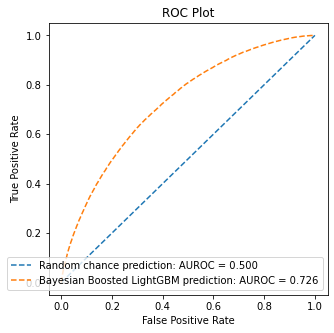

In [16]:
plt.figure(figsize=(5,5))
plt.plot(r_fpr,r_tpr, linestyle='--', label='Random chance prediction: AUROC = %.3f' % (r_auc))
plt.plot(lg_fpr,lg_tpr, linestyle='--', label='Bayesian Boosted LightGBM prediction: AUROC = %.3f' % (lg_auc))

#Title
plt.title('ROC Plot')
#Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#Legend
plt.legend(loc='lower right')
plt.savefig('roc_plot.png')
plt.show()

In [28]:
binarizer = Binarizer(threshold=.5)
lgbin = binarizer.fit_transform([lg_probs])
np.unique(lgbin.ravel(),return_counts=True)
lgbin = np.reshape(lgbin,250397)
mcc = met.matthews_corrcoef(y_test, lgbin)
roc = met.roc_auc_score(y_test, lgbin)

print(met.classification_report(y_test,lgbin))
print('MCC-score=%.3f' % (mcc))
print('ROC AUC-score=%.3f' % (roc))

              precision    recall  f1-score   support

           0       0.89      0.65      0.75    200129
           1       0.33      0.68      0.44     50268

    accuracy                           0.65    250397
   macro avg       0.61      0.66      0.59    250397
weighted avg       0.78      0.65      0.69    250397

MCC-score=0.266
ROC AUC-score=0.664


Confusion matrix, without normalization
[[129201  70928]
 [ 15979  34289]]
Normalized confusion matrix
[[0.65 0.35]
 [0.32 0.68]]


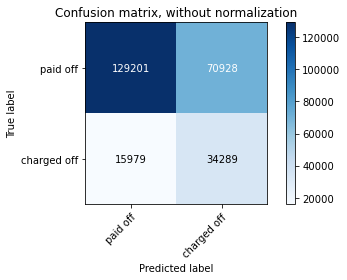

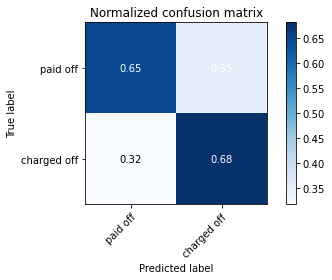

In [29]:
class_names=['paid off','charged off'] # name  of classes

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
#     # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.xlim(-0.5, len(np.unique(y))-0.5)
    plt.ylim(len(np.unique(y))-0.5, -0.5)
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, lgbin, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, lgbin, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.savefig('conf_matrix0.png')

plt.show()

In [32]:
binarizer = Binarizer(threshold=.4)
lgbin = binarizer.fit_transform([lg_probs])
np.unique(lgbin.ravel(),return_counts=True)
lgbin = np.reshape(lgbin,250397)
mcc = met.matthews_corrcoef(y_test, lgbin)
roc = met.roc_auc_score(y_test, lgbin)

print(met.classification_report(y_test,lgbin))
print('MCC-score=%.3f' % (mcc))
print('ROC AUC-score=%.3f' % (roc))

              precision    recall  f1-score   support

           0       0.92      0.47      0.62    200129
           1       0.28      0.83      0.42     50268

    accuracy                           0.54    250397
   macro avg       0.60      0.65      0.52    250397
weighted avg       0.79      0.54      0.58    250397

MCC-score=0.244
ROC AUC-score=0.650


Confusion matrix, without normalization
[[ 94570 105559]
 [  8688  41580]]
Normalized confusion matrix
[[0.47 0.53]
 [0.17 0.83]]


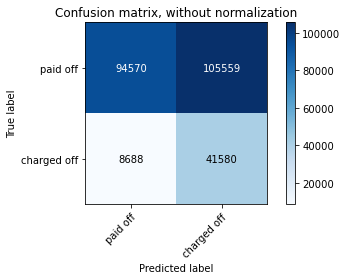

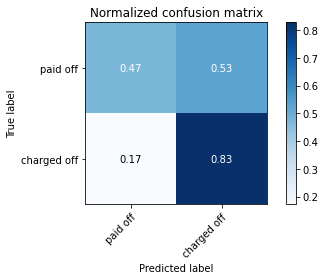

In [33]:
class_names=['paid off','charged off'] # name  of classes

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
#     # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.xlim(-0.5, len(np.unique(y))-0.5)
    plt.ylim(len(np.unique(y))-0.5, -0.5)
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, lgbin, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, lgbin, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.savefig('conf_matrix1.png')

plt.show()